# Valvestate simulation

[Schematics](https://drtube.com/schematics/marshall/pc0689.pdf)

In [2]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import csv
import sympy
import re

# Filters

Analog filters are discretectised using the method described in [DISCRETIZATION OF THE ’59 FENDER BASSMAN TONE STACK by David T. Yeh, Julius O. Smith](https://ccrma.stanford.edu/~dtyeh/papers/yeh06_dafx.pdf).

In summary, symbolic analysis is performed on the schematic in the s-domain, the the bilinear transform is used to genereate a z-domain transfer function, which can be implemented as an IIR filter.

They gloss over how exactly to perform the symbolic circuit analysis. I have used QSapecNG for this. This software performs symbolic analysis on a graphical schematic, so it is quite easy to use. Schematics are available for each circuit under the file mentioned in the relevant code snippet.

Lcapy, MATLAB SCAM, Wolfram SystemModeler could possibly work here. I have only tried lcapy, and altough it would be nice to do all the work inside Python, it was too slow to be usable.

In [3]:
def print_as_cpp_coefficients(a, b):
    for i in range(len(a)):    
        tmp = "float {0}{1} = {2};".format(b, i, a[i])
        #std::pow(\1, \2)
        print(re.sub(r"([a-zA-Z])\*\*(\d)", r"std::pow(\1, \2)", tmp))
    print()

## Input filter

This is the first stage of the amplifier, it's suspiciously similar to a tubescreamer pedal.

In [4]:
# TODO recreate this schematic, seems it was not saved properly

In [5]:
#input_filter.info
s, z, K = sympy.symbols("s z K")
tf_s = (s**2 + 2.23219e+06*s + 4.52694e+08)/(1 * s**2 + 104527*s + 4.52694e+08)
s_sub = K*(1-z**-1)/(1+z**-1)
tf_z = tf_s.subs(s, s_sub).normal().simplify().factor()
n, d = sympy.fraction(tf_z)
n_frac = sympy.poly(n, z)
d_frac = sympy.poly(d, z)
B = n_frac.coeffs()
A = d_frac.coeffs()

In [6]:
print_as_cpp_coefficients(B, "B")
print_as_cpp_coefficients(A, "A")

float B0 = 1.10449884469421e-9*std::pow(K, 2) + 0.00246545127613797*K + 0.5;
float B1 = 1.0 - 2.20899768938842e-9*std::pow(K, 2);
float B2 = 1.10449884469421e-9*std::pow(K, 2) - 0.00246545127613797*K + 0.5;

float A0 = 1.10449884469421e-9*std::pow(K, 2) + 0.000115449950739352*K + 0.5;
float A1 = 1.0 - 2.20899768938842e-9*std::pow(K, 2);
float A2 = 1.10449884469421e-9*std::pow(K, 2) - 0.000115449950739352*K + 0.5;



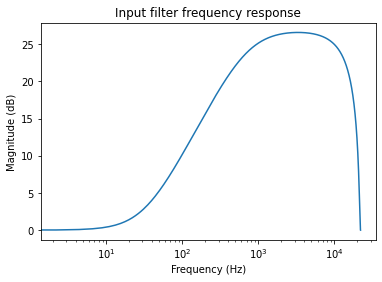

In [7]:
b = []
a = []
Fs = 44.1e3
k = 2*Fs
for i in range(len(B)):
    b.append(float(B[i].subs(K, k)))
    a.append(float(A[i].subs(K, k)))

f = signal.dlti(b, a)
w, H = signal.dfreqresp(f)

plt.figure()
plt.semilogx(w/2/np.pi*Fs, 20*np.log10(np.abs(H)))
plt.title("Input filter frequency response")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.show()

## Gain control

No QSapecNG schematic here, this one was done by hand! There are two sets of functions here, as this curcuit has two switchable modes (OD1/OD2).

/home/barabas/projects/software/valvestate/Docs/venv/lib/python3.9/site-packages/scipy/signal/filter_design.py:1630: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


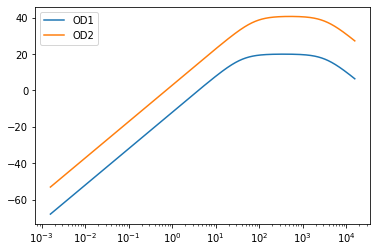

In [8]:
C1 = 220e-9
C2 = 47e-12
R1 = 22e3
R2 = 100e3
Rg = 1e6

B1 = [R1*Rg*C1, 0]
A1 = [R1*R2*Rg*C1*C2, R1*R2*C1 + R1*Rg*C2 + R2*Rg*C2, R1+R2]

B2 = [0,Rg*C1, 0]
R1 = 9.09e3
A2 = [R1*Rg*C1*C2, R1*C1 + Rg*C2, 1]

f1 = signal.lti(B1, A1)
f2 = signal.lti(B2, A2)
w1, H1 = signal.freqresp(f1)
w2, H2 = signal.freqresp(f2)
plt.semilogx(w1/2/np.pi, 20*np.log10(np.abs(H1)), label="OD1")
plt.semilogx(w2/2/np.pi, 20*np.log10(np.abs(H2)), label="OD2")
plt.legend()
plt.show()

In [9]:
s, z, K, Rg, g = sympy.symbols("s z K Rg g")
B1 = [R1*Rg*C1, 0]
A1 = [R1*R2*Rg*C1*C2, R1*R2*C1 + R1*Rg*C2 + R2*Rg*C2, R1+R2]

R1 = 9.09e3
B2 = [Rg*C1, 0]
A2 = [R1*Rg*C1*C2, R1*C1 + Rg*C2, 1]

tf1_s = ((B1[0]*s)/(A1[0]*s**2 + A1[1]*s + A1[2])).subs(Rg, 1e6*g)
tf2_s = ((B2[0]*s)/(A2[0]*s**2 + A2[1]*s + A2[2])).subs(Rg, 1e6*g)
s_sub = K*(1-z**-1)/(1+z**-1)
tf1_z = tf1_s.subs(s, s_sub).normal().simplify().factor()
tf2_z = tf2_s.subs(s, s_sub).normal().simplify().factor()
n1, d1 = sympy.fraction(tf1_z)
n2, d2 = sympy.fraction(tf2_z)
B1z = sympy.poly(n1, z).all_coeffs()
A1z = sympy.poly(d1, z).all_coeffs()
B2z = sympy.poly(n2, z).all_coeffs()
A2z = sympy.poly(d2, z).all_coeffs()

In [10]:
print_as_cpp_coefficients(B1z, "B1")
print_as_cpp_coefficients(A1z, "A1")

print_as_cpp_coefficients(B2z, "B2")
print_as_cpp_coefficients(A2z, "A2")

float B10 = 0.00916582638188652*K*g;
float B11 = 0;
float B12 = -0.00916582638188652*K*g;

float A10 = 4.30793839948666e-8*std::pow(K, 2)*g + 2.35e-5*K*g + 0.000916582638188652*K + 0.5;
float A11 = -8.61587679897332e-8*std::pow(K, 2)*g + 1.0;
float A12 = 4.30793839948666e-8*std::pow(K, 2)*g - 2.35e-5*K*g - 0.000916582638188652*K + 0.5;

float B20 = 0.11*K*g;
float B21 = 0;
float B22 = -0.11*K*g;

float A20 = 4.69953e-8*std::pow(K, 2)*g + 2.35e-5*K*g + 0.0009999*K + 0.5;
float A21 = -9.39906e-8*std::pow(K, 2)*g + 1.0;
float A22 = 4.69953e-8*std::pow(K, 2)*g - 2.35e-5*K*g - 0.0009999*K + 0.5;



<ipython-input-11-79d4e46add18>:27: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(w1/2/np.pi*Fs, 20*np.log10(np.abs(H1)), label="OD1, g = {0}".format(gg))
<ipython-input-11-79d4e46add18>:28: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(w2/2/np.pi*Fs, 20*np.log10(np.abs(H2)), "--", label="OD2, g = {0}".format(gg), )
<ipython-input-11-79d4e46add18>:27: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(w1/2/np.pi*Fs, 20*np.log10(np.abs(H1)), label="OD1, g = {0}".format(gg))
<ipython-input-11-79d4e46add18>:28: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(w2/2/np.pi*Fs, 20*np.log10(np.abs(H2)), "--", label="OD2, g = {0}".format(gg), )
<ipython-input-11-79d4e46add18>:27: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(w1/2/np.pi*Fs, 20*np.log10(np.abs(H1)), label="OD1, g = {0}".format(gg))
<ipython-input-11-79d4e46add18>:28: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(w

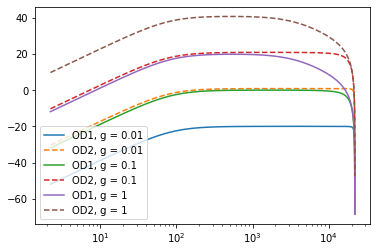

In [11]:
b1 = []
a1 = []
b2 = []
a2 = []

G = [0.01, 0.1, 1]

Fs = 44.1e3
k = 2*Fs
for gg in G:
    b1 = []
    a1 = []
    b2 = []
    a2 = []
    for i in range(len(B1z)):
        b1.append(float(B1z[i].subs(K, k).subs(g, gg)))
        a1.append(float(A1z[i].subs(K, k).subs(g, gg)))
        b2.append(float(B2z[i].subs(K, k).subs(g, gg)))
        a2.append(float(A2z[i].subs(K, k).subs(g, gg)))

    f1 = signal.dlti(b1, a1)
    w1, H1 = signal.dfreqresp(f1)

    f2 = signal.dlti(b2, a2)
    w2, H2 = signal.dfreqresp(f2)

    plt.semilogx(w1/2/np.pi*Fs, 20*np.log10(np.abs(H1)), label="OD1, g = {0}".format(gg))
    plt.semilogx(w2/2/np.pi*Fs, 20*np.log10(np.abs(H2)), "--", label="OD2, g = {0}".format(gg), )
plt.legend()
plt.show()

## Contour filter

In [12]:
#expression from QSapecNG
Rp1, Rp2, V1, s, p = sympy.symbols("Rp1 Rp2 V1 s p")
R1 = 4.7e3
R2 = 33e3
R3 = 47e3
R4 = 100e3
Rp = 100e3
C1 = 1e-9
C2 = 47e-9
C3 = 22e-9
C4 = 10e-9
#exp = (( C1 * C2 * C3 * R3 * R4 * Rp1 * Rp2 * V1 + C1 * C3 * C4 * R3 * R4 * Rp1 * Rp2 * V1 + C1 * C2 * C3 * R2 * R4 * Rp1 * Rp2 * V1 + C1 * C3 * C4 * R2 * R4 * Rp1 * Rp2 * V1 + C1 * C2 * C3 * R2 * R3 * R4 * Rp1 * V1 + C1 * C3 * C4 * R2 * R3 * R4 * Rp1 * V1 ) * s**3 + ( C2 * C3 * R4 * Rp1 * Rp2 * V1 + C3 * C4 * R4 * Rp1 * Rp2 * V1 + C1 * C2 * R3 * R4 * Rp1 * V1 + C1 * C3 * R3 * R4 * Rp2 * V1 + C1 * C4 * R3 * R4 * Rp1 * V1 + C1 * C2 * R2 * R4 * Rp1 * V1 + C1 * C3 * R2 * R4 * Rp2 * V1 + C1 * C4 * R2 * R4 * Rp1 * V1 + C1 * C3 * R2 * R3 * R4 * V1 ) * s**2 + ( C2 * R4 * Rp1 * V1 + C3 * R4 * Rp2 * V1 + C4 * R4 * Rp1 * V1 + C1 * R3 * R4 * V1 + C1 * R2 * R4 * V1 ) * s + R4 * V1) / (( ( - C1 * C2 * C3 * C4 * R1 * R3 * R4 * Rp1 * Rp2 ) + ( - C1 * C2 * C3 * C4 * R1 * R2 * R4 * Rp1 * Rp2 ) + ( - C1 * C2 * C3 * C4 * R1 * R2 * R3 * R4 * Rp1 ) ) * s**4 + ( ( - C1 * C2 * C3 * R3 * R4 * Rp1 * Rp2 ) + ( - C1 * C3 * C4 * R3 * R4 * Rp1 * Rp2 ) + ( - C1 * C2 * C3 * R2 * R4 * Rp1 * Rp2 ) + ( - C1 * C3 * C4 * R2 * R4 * Rp1 * Rp2 ) + ( - C1 * C2 * C3 * R2 * R3 * R4 * Rp1 ) + ( - C1 * C3 * C4 * R2 * R3 * R4 * Rp1 ) + ( - C2 * C3 * C4 * R1 * R4 * Rp1 * Rp2 ) + ( - C1 * C2 * C3 * R1 * R3 * R4 * Rp2 ) + ( - C1 * C2 * C3 * R1 * R3 * R4 * Rp1 ) + ( - C1 * C2 * C3 * R1 * R3 * Rp1 * Rp2 ) + ( - C1 * C2 * C4 * R1 * R3 * R4 * Rp1 ) + ( - C1 * C3 * C4 * R1 * R3 * R4 * Rp1 ) + ( - C1 * C3 * C4 * R1 * R3 * Rp1 * Rp2 ) + ( - C2 * C3 * C4 * R1 * R3 * Rp1 * Rp2 ) + ( - C1 * C2 * C3 * R1 * R2 * R4 * Rp2 ) + ( - C1 * C2 * C3 * R1 * R2 * R4 * Rp1 ) + ( - C1 * C2 * C3 * R1 * R2 * Rp1 * Rp2 ) + ( - C1 * C2 * C4 * R1 * R2 * R4 * Rp1 ) + ( - C1 * C3 * C4 * R1 * R2 * R4 * Rp1 ) + ( - C1 * C3 * C4 * R1 * R2 * Rp1 * Rp2 ) + ( - C2 * C3 * C4 * R1 * R2 * R4 * Rp1 ) + ( - C2 * C3 * C4 * R1 * R2 * Rp1 * Rp2 ) + ( - C1 * C2 * C3 * R1 * R2 * R3 * R4 ) + ( - C1 * C2 * C3 * R1 * R2 * R3 * Rp1 ) + ( - C1 * C3 * C4 * R1 * R2 * R3 * Rp1 ) + ( - C2 * C3 * C4 * R1 * R2 * R3 * Rp1 ) ) * s**3 + ( ( - C2 * C3 * R4 * Rp1 * Rp2 ) + ( - C3 * C4 * R4 * Rp1 * Rp2 ) + ( - C1 * C2 * R3 * R4 * Rp1 ) + ( - C1 * C3 * R3 * R4 * Rp2 ) + ( - C1 * C4 * R3 * R4 * Rp1 ) + ( - C2 * C3 * R3 * Rp1 * Rp2 ) + ( - C3 * C4 * R3 * Rp1 * Rp2 ) + ( - C1 * C2 * R2 * R4 * Rp1 ) + ( - C1 * C3 * R2 * R4 * Rp2 ) + ( - C1 * C4 * R2 * R4 * Rp1 ) + ( - C2 * C3 * R2 * R4 * Rp1 ) + ( - C2 * C3 * R2 * Rp1 * Rp2 ) + ( - C3 * C4 * R2 * R4 * Rp1 ) + ( - C3 * C4 * R2 * Rp1 * Rp2 ) + ( - C1 * C3 * R2 * R3 * R4 ) + ( - C2 * C3 * R2 * R3 * Rp1 ) + ( - C3 * C4 * R2 * R3 * Rp1 ) + ( - C2 * C3 * R1 * R4 * Rp2 ) + ( - C2 * C3 * R1 * R4 * Rp1 ) + ( - C2 * C3 * R1 * Rp1 * Rp2 ) + ( - C2 * C4 * R1 * R4 * Rp1 ) + ( - C3 * C4 * R1 * R4 * Rp1 ) + ( - C3 * C4 * R1 * Rp1 * Rp2 ) + ( - C1 * C2 * R1 * R3 * R4 ) + ( - C1 * C2 * R1 * R3 * Rp1 ) + ( - C1 * C3 * R1 * R3 * R4 ) + ( - C1 * C3 * R1 * R3 * Rp2 ) + ( - C1 * C4 * R1 * R3 * Rp1 ) + ( - C2 * C3 * R1 * R3 * Rp2 ) + ( - C2 * C3 * R1 * R3 * Rp1 ) + ( - C2 * C4 * R1 * R3 * Rp1 ) + ( - C3 * C4 * R1 * R3 * Rp1 ) + ( - C1 * C2 * R1 * R2 * R4 ) + ( - C1 * C2 * R1 * R2 * Rp1 ) + ( - C1 * C3 * R1 * R2 * R4 ) + ( - C1 * C3 * R1 * R2 * Rp2 ) + ( - C1 * C4 * R1 * R2 * Rp1 ) + ( - C2 * C3 * R1 * R2 * R4 ) + ( - C2 * C3 * R1 * R2 * Rp2 ) + ( - C2 * C4 * R1 * R2 * Rp1 ) + ( - C1 * C3 * R1 * R2 * R3 ) + ( - C2 * C3 * R1 * R2 * R3 ) ) * s**2 + ( ( - C2 * R4 * Rp1 ) + ( - C3 * R4 * Rp2 ) + ( - C4 * R4 * Rp1 ) + ( - C1 * R3 * R4 ) + ( - C2 * R3 * Rp1 ) + ( - C3 * R3 * Rp2 ) + ( - C4 * R3 * Rp1 ) + ( - C1 * R2 * R4 ) + ( - C2 * R2 * Rp1 ) + ( - C3 * R2 * R4 ) + ( - C3 * R2 * Rp2 ) + ( - C4 * R2 * Rp1 ) + ( - C3 * R2 * R3 ) + ( - C2 * R1 * R4 ) + ( - C2 * R1 * Rp1 ) + ( - C3 * R1 * R4 ) + ( - C3 * R1 * Rp2 ) + ( - C4 * R1 * Rp1 ) + ( - C1 * R1 * R3 ) + ( - C2 * R1 * R3 ) + ( - C3 * R1 * R3 ) + ( - C1 * R1 * R2 ) + ( - C2 * R1 * R2 ) ) * s + ( ( - R4 ) + ( - R3 ) + ( - R2 ) + ( - R1 ) ))
exp = (( 1.0032e-14 * Rp1 * Rp2 * V1 + 1.94495e-10 * Rp1 * V1 ) * s**3 + ( 1.254e-10 * Rp1 * Rp2 * V1 + 4.56e-07 * Rp1 * V1 + 1.76e-07 * Rp2 * V1 + 0.0034122 * V1 ) * s**2 + ( 0.0057 * Rp1 * V1 + 0.0022 * Rp2 * V1 + 8 * V1 ) * s + 100000 * V1)/(( 3.88784e-19 * Rp1 * Rp2 + 7.53755e-15 * Rp1 ) * s**4 + ( 1.92511e-14 * Rp1 * Rp2 + 5.04208e-10 * Rp1 + 3.88784e-11 * Rp2 + 7.53755e-07 ) * s**3 + ( 2.31614e-10 * Rp1 * Rp2 + 7.82459e-06 * Rp1 + 1.05904e-06 * Rp2 + 0.0297419 ) * s**2 + ( 0.0105279 * Rp1 + 0.0040634 * Rp2 + 170.06 ) * s + 184700)

exp_final = exp.subs(Rp1, Rp*p).subs(Rp2, Rp*(1-p)).subs(V1, 1)
n, d = sympy.fraction(exp_final)
n_poly = sympy.Poly(n,s)
d_poly = sympy.Poly(d,s)
B = n_poly.coeffs()
A = d_poly.coeffs()
B.insert(0, V1-V1)

In [13]:
print("B (length ", len(B), ") = ", B)
print("A (length ", len(A), ") = ", A)

B (length  5 ) =  [0, -0.00010032*p**2 + 0.0001197695*p, -1.254*p**2 + 1.282*p + 0.0210122, 350.0*p + 228.0, 100000.000000000]
A (length  5 ) =  [-3.88784e-9*p**2 + 4.641595e-9*p, -0.000192511*p**2 + 0.00023904396*p + 4.641595e-6, -2.31614*p**2 + 2.992695*p + 0.1356459, 646.45*p + 576.4, 184700.000000000]


/home/barabas/projects/software/valvestate/Docs/venv/lib/python3.9/site-packages/scipy/signal/filter_design.py:1630: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
/home/barabas/projects/software/valvestate/Docs/venv/lib/python3.9/site-packages/scipy/signal/filter_design.py:1630: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
/home/barabas/projects/software/valvestate/Docs/venv/lib/python3.9/site-packages/scipy/signal/filter_design.py:1630: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
/home/barabas/projects/software/valvestate/Docs/venv/lib/python3.9/site-packages/scipy/signal/filter_design.py:1630: BadCoefficien

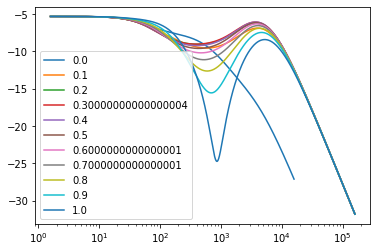

In [14]:
tf = []
P = np.linspace(0, 1, 11)
for pp in P:
    b = []
    a = []
    for i in range(len(B)):
        b.append(float(B[i].subs(p, pp)))
        a.append(float(A[i].subs(p, pp)))
             
    tf = signal.TransferFunction(b, a)
    w, H = signal.freqresp(tf)
    plt.semilogx(w/2/np.pi, 20*np.log10(np.abs(H)), label=pp)
plt.legend()
plt.show()

In [15]:
#bilinear transform
s, z, K = sympy.symbols("s z K")

b0 = B[0]
b1 = B[1]
b2 = B[2]
b3 = B[3]
b4 = B[4]
a0 = A[0]
a1 = A[1]
a2 = A[2]
a3 = A[3]
a4 = A[4]

tf = (b0*s**4 + b1*s**3 + b2*s**2 + b3*s + b4)/(a0*s**4 + a1*s**3 + a2*s**2 + a3*s + a4)
s_sub = K*(1-z**-1)/(1+z**-1)

In [16]:
z_tf = tf.subs(s, s_sub).normal().simplify().expand()
n, d = sympy.fraction(z_tf.factor())
n_poly = sympy.poly(n, z)
d_poly = sympy.poly(d, z)
Bz = n_poly.coeffs()
Az = d_poly.coeffs()

In [17]:
#print filter coefficients in c++ format

print_as_cpp_coefficients(Bz, "B")
print_as_cpp_coefficients(Az, "A")

float B0 = 9.05251759610179e-11*std::pow(K, 3)*std::pow(p, 2) - 1.08075708355892e-10*std::pow(K, 3)*p + 1.13156469951272e-6*std::pow(K, 2)*std::pow(p, 2) - 1.15683089695001e-6*std::pow(K, 2)*p - 1.89606569211334e-8*std::pow(K, 2) - 0.000315827467966071*K*p - 0.000205739036275041*K - 0.0902364194188775;
float B1 = -1.81050351922036e-10*std::pow(K, 3)*std::pow(p, 2) + 2.16151416711785e-10*std::pow(K, 3)*p - 0.000631654935932142*K*p - 0.000411478072550081*K - 0.36094567767551;
float B2 = -2.26312939902545e-6*std::pow(K, 2)*std::pow(p, 2) + 2.31366179390002e-6*std::pow(K, 2)*p + 3.79213138422667e-8*std::pow(K, 2) - 0.541418516513265;
float B3 = 1.81050351922036e-10*std::pow(K, 3)*std::pow(p, 2) - 2.16151416711785e-10*std::pow(K, 3)*p + 0.000631654935932142*K*p + 0.000411478072550081*K - 0.36094567767551;
float B4 = -9.05251759610179e-11*std::pow(K, 3)*std::pow(p, 2) + 1.08075708355892e-10*std::pow(K, 3)*p + 1.13156469951272e-6*std::pow(K, 2)*std::pow(p, 2) - 1.15683089695001e-6*std::pow(K,

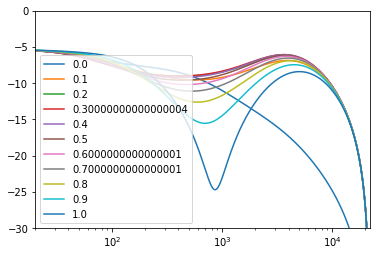

In [18]:
tf = []
Fs = 44.1e3
P = np.linspace(0, 1, 11)
k = 2*Fs
w = np.linspace(0, 1, 100)
for pp in P:
    b = []
    a = []
    for i in range(len(Bz)):
        b.append(float(Bz[i].subs(p, pp).subs(K, k)))
        a.append(float(Az[i].subs(p, pp).subs(K, k)))

    tf = signal.dlti(b, a)
    w, H = signal.dfreqresp(tf)
    plt.semilogx(w/2/np.pi*Fs, 20*np.log10(np.abs(H)), label=pp)
plt.legend()
plt.ylim(-30, 0)
plt.xlim(20, Fs/2)
plt.show()